In [28]:
import pandas as pd
import numpy as np
from dateutil.parser import parse
import matplotlib as mpl
from matplotlib.pyplot import MultipleLocator
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from datetime import datetime
import time
import random
from scipy.interpolate import interp1d
import statsmodels.api as sm
import seaborn as sns
import itertools
from statsmodels.tsa.stattools import adfuller
from numpy import mean
import math
import os
from statsmodels.graphics.api import qqplot
from statsmodels.stats.stattools import durbin_watson #DW检验
from pmdarima.arima import auto_arima

In [29]:
# 绘图plt设置中文和负号正常显示
plt.rcParams['font.sans-serif'] = 'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False

In [30]:
def get_data_dir(dataname):
    father_dir = os.path.abspath('..')
    data_dir = father_dir + '\data'+f'\{dataname}'
    return data_dir

In [31]:
def read_file(filename):
    temp = filename.split(".")
    if temp[1] == "xlsx" or temp[1] == "xls":
        return pd.read_excel(get_data_dir(filename), index_col=0)
    elif temp[1] == "csv":
        return pd.read_csv(get_data_dir(filename), index_col=0)
    else:
        return "文件不存在或格式不符"

In [32]:
def plot_df(df, x, y, title="", xlabel='Index', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

In [33]:
def knn_mean(ts, n):
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            n_by_2 = np.ceil(n / 2)
            lower = np.max([0, int(i - n_by_2)])
            upper = np.min([len(ts) + 1, int(i + n_by_2)])
            ts_near = np.concatenate([ts[lower:i], ts[i:upper]])
            out[i] = np.nanmean(ts_near)
    return out

In [34]:
def plot_freq(df,KPI,num):
    df_freq = pd.DataFrame(index=df[KPI][0:num].index)
    df_freq['天数'] = [f'第{int(d / 24) + 1}天' for d in df[KPI][0:num].index]
    df_freq['小时'] = [f'{(d) % 24 + 1}' for d in df[KPI][0:2207].index]
    df_freq['values'] = df[KPI][0:num]

    # 绘图
    week_num = df_freq['天数'].unique()
    np.random.seed(100)
    mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(week_num), replace=False)
    plt.figure(figsize=(16, 12), dpi=80)
    for i, y in enumerate(week_num[0:-1]):
        plt.plot('小时', 'values', data=df_freq[df_freq["天数"] == y], color=mycolors[i], label=y)
    plt.gca().set(xlim=(0, 23), ylim=(70, 95), ylabel='$Memory Load$', xlabel='$Hour$')
    plt.yticks(fontsize=12, alpha=.7)
    plt.show()

In [35]:
def ADF_is_diff(adf):
    P_value = adf[0]
    p1 = adf[4]['1%']
    p5 = adf[4]['5%']
    p10 = adf[4]['10%']
    if P_value < p1 and P_value < p5 and P_value < p10:
        return False
    else:
        return True

In [36]:
def plot_BIC(timeSeries,p_min, p_max, q_min, q_max, d_min, d_max):
    results_bic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min, p_max + 1)],
                               columns=['MA{}'.format(i) for i in range(q_min, q_max + 1)])
    num = 1
    for p, d, q in itertools.product(range(p_min, p_max + 1),
                                     range(d_min, d_max + 1),
                                     range(q_min, q_max + 1)):
        if p == 0 and d == 0 and q == 0:
            results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = np.nan
            continue

        try:
            model = sm.tsa.ARIMA(timeSeries, order=(p, d, q), #enforce_stationarity=False,enforce_invertibility=False,
                                 )
            results = model.fit()
            num += 1
            print(f"循环{num}次")
            results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = results.bic
        except:
            continue
    results_bic = results_bic[results_bic.columns].astype(float)
    return results_bic

In [37]:
def evaluate(truth, predict, n=None, p=None):
    error = []
    squaredError = []   # 差值平方
    absError = []       # 绝对误差
    truthDeviation = []     # 真实值与均值的差平方
    percentError = []       # 误差百分比
    for i in range(len(truth)):
        error.append(truth[i]-predict[i])
        percentError.append(abs(truth[i]-predict[i])/truth[i])
    for val in error:
        squaredError.append(val**2)
        absError.append(abs(val))
    truthMean = sum(truth) / len(truth)
    for val in truth:
        truthDeviation.append((val - truthMean) ** 2)

    MSE = sum(squaredError)/len(squaredError)   # 均方误差MSE
    RMSE = math.sqrt(MSE)                       # 均方根误差RMSE
    MAE = sum(absError)/len(absError)           # 平均绝对误差MAE
    R2 = 1 - sum(squaredError)/sum(truthDeviation)  # 决定系数
    MAPE = sum(percentError)/len(percentError)  # 平均百分比误差MAPE

    R2_adj = 1 - ((1-R2)(n-1))/(n-p-1)  # 矫正决定系数
    return MSE,RMSE,MAE,MAPE,R2,R2_adj

In [38]:
# 参数
filename = "服务器性能数据.xlsx"
KPI = "内存负载"
window = 24   # K-近邻插值的窗口大小
freq = 24   # 周期大小
is_lack = True
is_delete_freq = True
forecast_index = 2046   # 预测时刻索引
current_time = 6        # 预测时刻
h = 12                  # 预测未来h步
test_method = "DW"      # "DW"or"QQ"
# 1.读取data数据
df_original = read_file(filename)
# 2.在数据中建立深拷贝副本
df = df_original.copy(deep=True)
# 3.观察原始序列图
# plot_df(df, x=df.index, y=df[KPI], title=KPI)
# 4.缺失值补全
if is_lack:
    df[KPI] = knn_mean(df[KPI], window)
# 5.观察周期性
# num = len(df[KPI])
# plot_freq(df, KPI, num)
# 6.去除周期性因素
seasonal_series = []
if is_delete_freq:
    result_add = sm.tsa.seasonal_decompose(df[KPI], model='additive', period=24, extrapolate_trend='freq')
    for i in (result_add.seasonal)[0:freq].values:
        seasonal_series.append(i)
    df[KPI] -= result_add.seasonal
# 7.划分预测区间
train = df[KPI][0:forecast_index]
test = df_original[KPI][forecast_index: h+forecast_index]

In [39]:
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=450.950, Time=1.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=982.100, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=598.545, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=455.447, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=980.792, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=453.674, Time=1.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=451.998, Time=0.57 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=452.467, Time=0.82 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=452.140, Time=2.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=456.701, Time=0.39 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=451.487, Time=1.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=451.337, Time=0.92 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=454.532, Time=1.59 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=449.351, Time=0.57 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=452.0

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [40]:
gdp_pre=model.predict(n_periods=len(test),return_conf_int=True)

In [41]:
gdp_pre

(array([70.32801613, 70.3254067 , 70.32503515, 70.32544537, 70.3253587 ,
        70.32533966, 70.32535538, 70.3253526 , 70.3253517 , 70.3253523 ,
        70.32535221, 70.32535217]),
 array([[69.80003678, 70.85599548],
        [69.35334828, 71.29746512],
        [69.06001668, 71.59005362],
        [68.83971842, 71.81117232],
        [68.64292166, 72.00779573],
        [68.46681093, 72.18386839],
        [68.30650954, 72.34420122],
        [68.15788535, 72.49281984],
        [68.01881116, 72.63189224],
        [67.88767549, 72.7630291 ],
        [67.76323852, 72.8874659 ],
        [67.64457106, 73.00613328]]))

In [43]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2046
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -219.675
Date:                Wed, 30 Dec 2020   AIC                            449.351
Time:                        20:32:56   BIC                            477.466
Sample:                             0   HQIC                           459.663
                               - 2046                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3133      0.204     -1.539      0.124      -0.712       0.086
ar.L2         -0.1126      0.019     -5.812      0.000      -0.151      -0.075
ma.L1          0.8591      0.204      4.218      0.000       0.460       1.258
ma.L2          0.2711      0.109      2.480      0.013       0.057       0.485
sigma2         0.0726      0.000    432.322      0.000       0.072       0.073
===================================================================================
Ljung-Box (Q):                       21.32   Jarque-Bera (JB):          12582711.77
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               5.59   Skew:                           -13.66
Prob(H) (two-sided):                  0.00   Kurtosis:                       386.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [45]:
len(model.resid())

2046

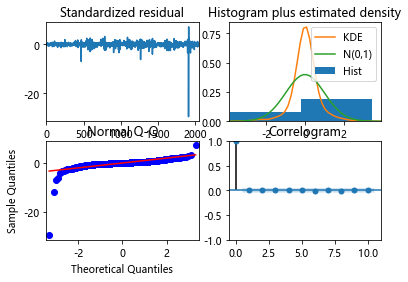

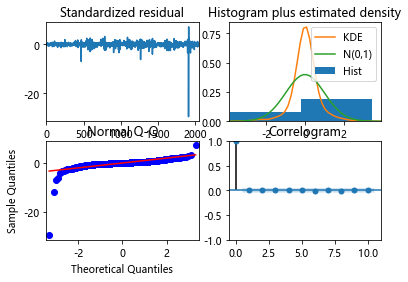

In [46]:
model.plot_diagnostics()

In [16]:
model = sm.tsa.ARIMA(train.values, order=(2, 1, 2))
result = model.fit()
forecast, stderr, conf = result.forecast(12)

In [17]:
forecast

array([70.32426202, 70.31581328, 70.30965876, 70.30450781, 70.29878302,
       70.29312482, 70.28751056, 70.281875  , 70.27624115, 70.27060918,
       70.26497642, 70.25934369])